# Descarga de Datos

In [1]:
# Importar librerías
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}')

Pandas Version: 2.2.2


In [3]:
np.set_printoptions(suppress=True)

# En produccion eliminar, se incluye por informacion
print(f'Numpy version: {np.__version__}')

Numpy version: 2.0.2


In [4]:
warnings.filterwarnings("ignore")

In [5]:
# Para pandas: todos los floats en decimales normales, hasta 6 cifras decimales
pd.set_option('display.float_format', '{:.6f}'.format)

# Para numpy: print de arrays sin notación científica
np.set_printoptions(suppress=True, precision=6)

In [6]:
# Definir Parámetros
ticker = "SPY"
inicio = "1993-01-29"
final = "2025-06-30"

In [7]:
# Descargar datos diarios
df = yf.download(tickers=ticker, start=inicio, end=final, interval="1d", multi_level_index=False)
print(df.head())
print(df.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open   Volume
Date                                                       
1993-01-29 24.380449 24.397790 24.276408 24.397790  1003200
1993-02-01 24.553843 24.553843 24.397780 24.397780   480500
1993-02-02 24.605860 24.623200 24.484478 24.536499   201300
1993-02-03 24.865984 24.883324 24.623220 24.640560   529400
1993-02-04 24.970018 25.022039 24.675233 24.952678   531500
                Close       High        Low       Open    Volume
Date                                                            
2025-06-23 600.150024 600.539978 591.890015 595.039978  87426000
2025-06-24 606.780029 607.849976 603.409973 604.330017  67735300
2025-06-25 607.119995 608.609985 605.539978 607.909973  62114800
2025-06-26 611.869995 612.309998 608.369995 608.989990  78548400
2025-06-27 614.909973 616.390015 610.830017 612.880005  86258400


In [8]:
# Agregar el ATR(20) al dataframe

# Paso 1: desplazamos el Close para obtener el Close del día anterior
df['Prev_Close'] = df['Close'].shift(1)

# Paso 2: calculamos las tres componentes del True Range (TR)
df['TR1'] = df['High'] - df['Low']
df['TR2'] = (df['High'] - df['Prev_Close']).abs()
df['TR3'] = (df['Low']  - df['Prev_Close']).abs()

# Paso 3: el True Range es el máximo de esas tres series
df['TR'] = df[['TR1', 'TR2', 'TR3']].max(axis=1)

# Paso 4: calculamos el ATR(20) como media móvil simple de 20 periodos de TR
df['ATR20'] = df['TR'].rolling(window=20, min_periods=20).mean()

# Paso 5 (opcional): limpiar columnas auxiliares
df.drop(columns=['Prev_Close', 'TR1', 'TR2', 'TR3', 'TR'], inplace=True)

# Eliminar las filas NaN
df.dropna(inplace=True)

# Ahora df incluye la columna 'ATR20'
df.tail()

,Close,High,Low,Open,Volume,ATR20
Date,,,,,,
2025-06-23,600.150024,600.539978,591.890015,595.039978,87426000,6.538930
2025-06-24,606.780029,607.849976,603.409973,604.330017,67735300,6.550528
2025-06-25,607.119995,608.609985,605.539978,607.909973,62114800,6.061927
2025-06-26,611.869995,612.309998,608.369995,608.989990,78548400,6.033277
2025-06-27,614.909973,616.390015,610.830017,612.880005,86258400,5.955828


# Cración de Eventos Informativos

In [9]:
# Parámetros
TP_SL_MULT  = 2.0  # multiplicador para TP y SL (2×ATR20)
UMBRAL_MULT = 2.0  # threshold = ATR20 * UMBRAL_MULT

# Asumimos que `df` ya contiene las columnas:
# 'Open', 'High', 'Low', 'Close', 'Volume', 'ATR20' (sin NaN en ATR20)

barras_info = []

# 1) Evento inicial (fila 0)
row0      = df.iloc[0]
price_ref = row0['Close']
atr_ref   = row0['ATR20']
idx0      = df.index[0]

barras_info.append({
    "Fecha_Cierre":  idx0,
    "Precio_Cierre": price_ref,
    "Volume":        np.nan,
    "ATR20":         atr_ref
})

vol_acum = 0.0

# 2) Iteración para detectar y registrar eventos
for i in range(1, len(df)):
    row      = df.iloc[i]
    vol_acum += row['Volume']
    o, h, l  = row['Open'], row['High'], row['Low']

    # Calculamos niveles basados en el evento previo
    threshold = atr_ref * UMBRAL_MULT
    tp_level  = price_ref + threshold
    sl_level  = price_ref - threshold

    cierre = None

    # 2.1 GAP: si la apertura cruza el threshold
    if o >= tp_level or o <= sl_level:
        cierre = o

    # 2.2 Cruce intravela al alza
    elif h >= tp_level:
        cierre = tp_level

    # 2.3 Cruce intravela a la baja
    elif l <= sl_level:
        cierre = sl_level

    if cierre is None:
        continue  # no hubo evento en esta vela

    # 3) Registramos el evento
    barras_info.append({
        "Fecha_Cierre":  df.index[i],
        "Precio_Cierre": cierre,
        "Volume":        vol_acum,
        "ATR20":         row['ATR20']
    })

    # 4) Preparamos variables para el siguiente evento
    price_ref = cierre
    atr_ref   = row['ATR20']
    vol_acum  = 0.0

# 5) Construcción del DataFrame final y cálculo de TP/SL
df_barras = pd.DataFrame(barras_info)
df_barras['TP'] = df_barras['Precio_Cierre'] + TP_SL_MULT * df_barras['ATR20']
df_barras['SL'] = df_barras['Precio_Cierre'] - TP_SL_MULT * df_barras['ATR20']


print(f"Total de barras informativas: {len(df_barras)}")
display(df_barras.head(10))

Total de barras informativas: 1005


,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL
0,1993-02-26,24.640549,NaN,0.230625,25.101799,24.179298
1,1993-03-08,25.101799,709300.000000,0.250567,25.602933,24.600665
2,1993-04-02,24.600665,2498800.000000,0.219892,25.040449,24.160881
3,1993-04-12,25.040449,859200.000000,0.201942,25.444332,24.636565
4,1993-04-22,24.636565,1064300.000000,0.208195,25.052956,24.220174
5,1993-04-26,24.220174,168600.000000,0.215164,24.650503,23.789846
6,1993-04-30,24.650503,416200.000000,0.222133,25.094768,24.206238
7,1993-05-19,25.094768,1030800.000000,0.214294,25.523355,24.666180
8,1993-06-01,25.523355,805500.000000,0.206453,25.936262,25.110449
9,1993-06-08,25.087948,299800.000000,0.216033,25.520015,24.655882


# Etiquetar la Variable Objetivo

In [10]:
# Etiqueta: 1 si Precio_Cierre siguiente es mayor a Precio_Cierre actual, de lo contario, 0
df_barras['Objetivo'] = (df_barras['Precio_Cierre'].shift(-1) > df_barras['Precio_Cierre']).astype(int)

# Construir Variables Independientes

In [11]:
# VIX
# Definir Parámetros
ticker_vix = "^VIX"
inicio_vix = "1993-01-29"
final_vix = "2025-06-30"

In [12]:
# Descargar datos diarios
vix = yf.download(tickers=ticker_vix, start=inicio_vix, end=final_vix, interval="1d", multi_level_index=False)
print(vix.head())
print(vix.tail())

[*********************100%***********************]  1 of 1 completed

               Close      High       Low      Open  Volume
Date                                                      
1993-01-29 12.420000 13.160000 12.420000 12.490000       0
1993-02-01 12.330000 12.920000 12.180000 12.510000       0
1993-02-02 12.250000 12.890000 12.220000 12.470000       0
1993-02-03 12.120000 12.340000 11.790000 11.980000       0
1993-02-04 12.290000 12.840000 11.690000 11.860000       0
               Close      High       Low      Open  Volume
Date                                                      
2025-06-23 19.830000 22.510000 19.820000 21.150000       0
2025-06-24 17.480000 18.719999 17.330000 18.190001       0
2025-06-25 16.760000 17.510000 16.680000 17.280001       0
2025-06-26 16.590000 16.780001 16.110001 16.670000       0
2025-06-27 16.320000 17.290001 16.120001 16.309999       0


In [13]:
# --- 1. Asegurar tipos y nombres ---
# Convierte Fecha_Inicio a datetime (si no lo está ya)
df_barras['Fecha_Cierre'] = pd.to_datetime(df_barras['Fecha_Cierre'])
# Asegura que el índice de vix sea datetime
vix.index = pd.to_datetime(vix.index)

# --- 2. Mapear el Open de VIX al df_barras ---
# Renombra la serie para claridad
serie_vix = vix['Open'].rename('VIX_Open')

# Usamos map() para asignar, vía índice de fechas
df_barras['VIX_Open'] = df_barras['Fecha_Cierre'].map(serie_vix)

# --- 3. Verificar resultado ---
print(df_barras[['Fecha_Cierre', 'Precio_Cierre', 'VIX_Open']].head())

  Fecha_Cierre  Precio_Cierre  VIX_Open
0   1993-02-26      24.640549 13.470000
1   1993-03-08      25.101799 15.000000
2   1993-04-02      24.600665 14.270000
3   1993-04-12      25.040449 12.330000
4   1993-04-22      24.636565 11.580000


In [14]:
# Retorno de los últimos 10 días
df_barras['Retornos_10'] = df_barras['Precio_Cierre'].pct_change(periods=10)

In [15]:
df_barras.head(6)

,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL,Objetivo,VIX_Open,Retornos_10
0,1993-02-26,24.640549,NaN,0.230625,25.101799,24.179298,1,13.470000,NaN
1,1993-03-08,25.101799,709300.000000,0.250567,25.602933,24.600665,0,15.000000,NaN
2,1993-04-02,24.600665,2498800.000000,0.219892,25.040449,24.160881,1,14.270000,NaN
3,1993-04-12,25.040449,859200.000000,0.201942,25.444332,24.636565,0,12.330000,NaN
4,1993-04-22,24.636565,1064300.000000,0.208195,25.052956,24.220174,0,11.580000,NaN
5,1993-04-26,24.220174,168600.000000,0.215164,24.650503,23.789846,1,14.060000,NaN


In [16]:
# Eliminar columnas con NaN
df_barras.dropna(inplace=True)

In [17]:
# Resetear el index
df_barras.reset_index(drop=True, inplace=True)

In [18]:
df_barras.head()

,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL,Objetivo,VIX_Open,Retornos_10
0,1993-08-16,25.520015,12847800.000000,0.145632,25.811280,25.228750,1,12.370000,0.035692
1,1993-08-24,25.811280,1181800.000000,0.139493,26.090266,25.532294,1,11.940000,0.028264
2,1993-08-26,26.090266,362300.000000,0.144756,26.379778,25.800753,0,11.850000,0.060551
3,1993-09-08,25.800753,1981400.000000,0.150895,26.102544,25.498963,1,12.260000,0.030363
4,1993-09-13,26.143034,412600.000000,0.157914,26.458861,25.827206,0,11.670000,0.061148


# Entrenamiento y Evaluación HMM

In [19]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 6.0 MB/s eta 0:00:00


In [20]:
from hmmlearn.hmm import GaussianHMM

# --- 1) Parámetros ------------------------------------------------------------
n_estados    = 4      # número de regímenes que deseas modelar
n_iteraciones = 200   # iters para el EM del HMM
random_state = 42     # para reproducibilidad

# --- 2) Preparar el dataset de entrenamiento --------------------------------
df_train = df_barras.iloc[:600].copy()
X_train  = df_train[['VIX_Open', 'Retornos_10']].values   # shape (500, 2)

# --- 3) Instanciar y entrenar el HMM ----------------------------------------
hmm = GaussianHMM(
    n_components   = n_estados,
    covariance_type= 'full',
    n_iter         = n_iteraciones,
    random_state   = random_state
)

hmm.fit(X_train)   # EM usando sólo los primeros 500 eventos

# --- 4) Etiquetar cada evento con su estado latente -------------------------
estados_train = hmm.predict(X_train)
df_train['Estado'] = estados_train

# --- 5) Inspección rápida ----------------------------------------------------
print("Conteo de observaciones por Estado en train:")
print(df_train['Estado'].value_counts(), "\n")

print("Medias de VIX y Retorno_10 por Estado:")
print(pd.DataFrame(
    hmm.means_,
    columns=['VIX_Open_μ', 'Retorno10_μ']
))

Conteo de observaciones por Estado en train:
Estado
1    164
0    159
2    146
3    131
Name: count, dtype: int64 

Medias de VIX y Retorno_10 por Estado:
   VIX_Open_μ  Retorno10_μ
0   12.623966     0.055833
1   21.621987     0.117425
2   31.612553    -0.082826
3   17.707083     0.025094


**Buy and Hold en el período**

In [21]:
# 1) Parámetros
capital = 100_000.0

# 2) Serie de precios de Buy & Hold
#    Usamos el Precio_Cierre de cada evento como precio de mercado
precios = df_train['Precio_Cierre'].reset_index(drop=True)
fechas  = pd.to_datetime(df_train['Fecha_Cierre'].reset_index(drop=True))

# 3) Curva de equity
equity = capital * (precios / precios.iloc[0])

# 4) Total Return
total_return = equity.iloc[-1] / capital - 1

# 5) CAGR
dias = (fechas.iloc[-1] - fechas.iloc[0]).days
años = dias / 365.25
cagr = (equity.iloc[-1] / equity.iloc[0]) ** (1/años) - 1

# 6) Retornos diarios de evento y exceso (supuesto RF=0)
retornos = equity.pct_change().dropna()
ret_exceso = retornos  # si RF diario = 0

# 7) Hit-Rate: proporción de retornos positivos
hit_rate = (retornos > 0).sum() / len(retornos)

# 8) Sharpe Ratio
sharpe = (ret_exceso.mean() / ret_exceso.std()) * np.sqrt(252)

# 9) Sortino Ratio
ret_neg = ret_exceso[ret_exceso < 0]
sortino = (ret_exceso.mean() / ret_neg.std()) * np.sqrt(252)

# 10) Maximum Drawdown (MDD)
running_max = equity.cummax()
drawdowns = (running_max - equity) / running_max
mdd = drawdowns.max()

# 11) Calmar Ratio
calmar = cagr / mdd

# 12) Time Under Water (TUW)
#    Número de eventos bajo el máximo anterior / total de eventos
tuw = (equity < running_max).sum() / len(equity)

# 13) Exposure Efficiency
#    Para Buy & Hold siempre estás 100% invertido → exposición constante = 1
#    Definimos: EE = Total Return / exposición_media
exposure = np.ones_like(equity)
ee = total_return / exposure.mean()

# 14) Mostrar resultados
print(f"CAGR:               {cagr:.2%}")
print(f"Sharpe Ratio:       {sharpe:.2f}")
print(f"Sortino Ratio:      {sortino:.2f}")
print(f"Maximum Drawdown:   {mdd:.2%}")
print(f"Calmar Ratio:       {calmar:.2f}")
print(f"Hit-Rate:           {hit_rate:.2%}")
print(f"Time Under Water:   {tuw:.2%}")
print(f"Exposure Efficiency:{ee:.2%}")

CAGR:               8.53%
Sharpe Ratio:       1.50
Sortino Ratio:      2.90
Maximum Drawdown:   53.38%
Calmar Ratio:       0.16
Hit-Rate:           56.26%
Time Under Water:   80.83%
Exposure Efficiency:407.53%


**Buy and Hold por estado HMM**

In [22]:
def event_metrics(df, capital=100_000.0):
    """
    Calcula métricas sobre la serie de retornos de eventos en df:
      - 'Retorno_pct' debe existir en df
      - 'Fecha_Cierre' datetime
    Devuelve un dict con Total Return, CAGR, Sharpe, Sortino,
    MDD, Calmar, Hit-rate, Time Under Water y Exposure Efficiency.
    """
    df = df.copy()
    # Asegurar Fecha_Cierre datetime
    df['Fecha_Cierre'] = pd.to_datetime(df['Fecha_Cierre'])

    # 1) Serie de retornos por evento
    rets = df['Retorno_pct'].reset_index(drop=True)

    # 2) Curva de equity
    equity = capital * (1 + rets).cumprod()

    # 3) Fechas real‑time para cálculo de años
    start_date = df['Fecha_Cierre'].iloc[0]
    end_date   = df['Fecha_Cierre'].iloc[-1]
    total_days = (end_date - start_date).days
    years      = total_days / 365.25 if total_days > 0 else np.nan

    # 4) Eventos por año
    events_per_year = len(rets) / years if years and years > 0 else np.nan

    # 5) Métricas básicas
    total_return = equity.iloc[-1] / capital - 1
    cagr         = (equity.iloc[-1] / capital) ** (1 / years) - 1 if years and years > 0 else np.nan

    mean_ret = rets.mean()
    std_ret  = rets.std(ddof=0)
    sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year) if std_ret and events_per_year and events_per_year > 0 else np.nan

    neg_rets = rets[rets < 0]
    std_neg  = neg_rets.std(ddof=0)
    sortino  = (mean_ret / std_neg) * np.sqrt(events_per_year) if std_neg and events_per_year and events_per_year > 0 else np.nan

    # 6) Drawdowns
    running_max = equity.cummax()
    drawdowns   = (running_max - equity) / running_max
    mdd         = drawdowns.max()

    # 7) Otras métricas
    calmar = cagr / mdd if mdd and not np.isnan(cagr) else np.nan
    tuw    = (equity < running_max).mean()
    ee     = total_return  # en eventos, exp. media = 1

    return {
        'Total Return':       total_return,
        'CAGR':               cagr,
        'Sharpe':             sharpe,
        'Sortino':            sortino,
        'MDD':                mdd,
        'Calmar':             calmar,
        'Hit-rate':           (rets > 0).mean(),
        'Time Under Water':   tuw,
        'Exposure Efficiency':ee
    }

# --- Preparar df_train --------------------------------------------------------
# Asume que df_train ya existe y tiene:
#   - 'Precio_Cierre'
#   - 'Fecha_Cierre'
#   - 'Estado' (etiqueta del HMM)

# 1) Calculamos Retorno_pct: retorno del evento t → t+1
df_train['Retorno_pct'] = (
    df_train['Precio_Cierre'].shift(-1) / df_train['Precio_Cierre'] - 1
)
# Eliminamos la última fila sin retorno
df_train = df_train.dropna(subset=['Retorno_pct']).reset_index(drop=True)

# ---  Aplicación por estado HMM  ---------------------------------------------
for estado in sorted(df_train['Estado'].unique()):
    df_est = df_train[df_train['Estado'] == estado]
    mets   = event_metrics(df_est)
    print(f"\n=== Estado HMM {estado} ===")
    print(f"Observaciones:      {len(df_est)}")
    print(f"Total Return:       {mets['Total Return']:.2%}")
    print(f"CAGR:               {mets['CAGR']:.2%}")
    print(f"Sharpe Ratio:       {mets['Sharpe']:.2f}")
    print(f"Sortino Ratio:      {mets['Sortino']:.2f}")
    print(f"Maximum Drawdown:   {mets['MDD']:.2%}")
    print(f"Calmar Ratio:       {mets['Calmar']:.2f}")
    print(f"Hit-Rate:           {mets['Hit-rate']:.2%}")
    print(f"Time Under Water:   {mets['Time Under Water']:.2%}")
    print(f"Exposure Efficiency:{mets['Exposure Efficiency']:.2%}")


=== Estado HMM 0 ===
Observaciones:      159
Total Return:       119.05%
CAGR:               4.04%
Sharpe Ratio:       0.89
Sortino Ratio:      4.89
Maximum Drawdown:   5.61%
Calmar Ratio:       0.72
Hit-Rate:           64.78%
Time Under Water:   52.83%
Exposure Efficiency:119.05%

=== Estado HMM 1 ===
Observaciones:      164
Total Return:       282.23%
CAGR:               8.99%
Sharpe Ratio:       0.91
Sortino Ratio:      3.06
Maximum Drawdown:   14.36%
Calmar Ratio:       0.63
Hit-Rate:           62.80%
Time Under Water:   54.27%
Exposure Efficiency:282.23%

=== Estado HMM 2 ===
Observaciones:      146
Total Return:       -44.66%
CAGR:               -4.11%
Sharpe Ratio:       -0.14
Sortino Ratio:      -0.36
Maximum Drawdown:   57.59%
Calmar Ratio:       -0.07
Hit-Rate:           44.52%
Time Under Water:   96.58%
Exposure Efficiency:-44.66%

=== Estado HMM 3 ===
Observaciones:      130
Total Return:       9.54%
CAGR:               0.47%
Sharpe Ratio:       0.10
Sortino Ratio:      0.

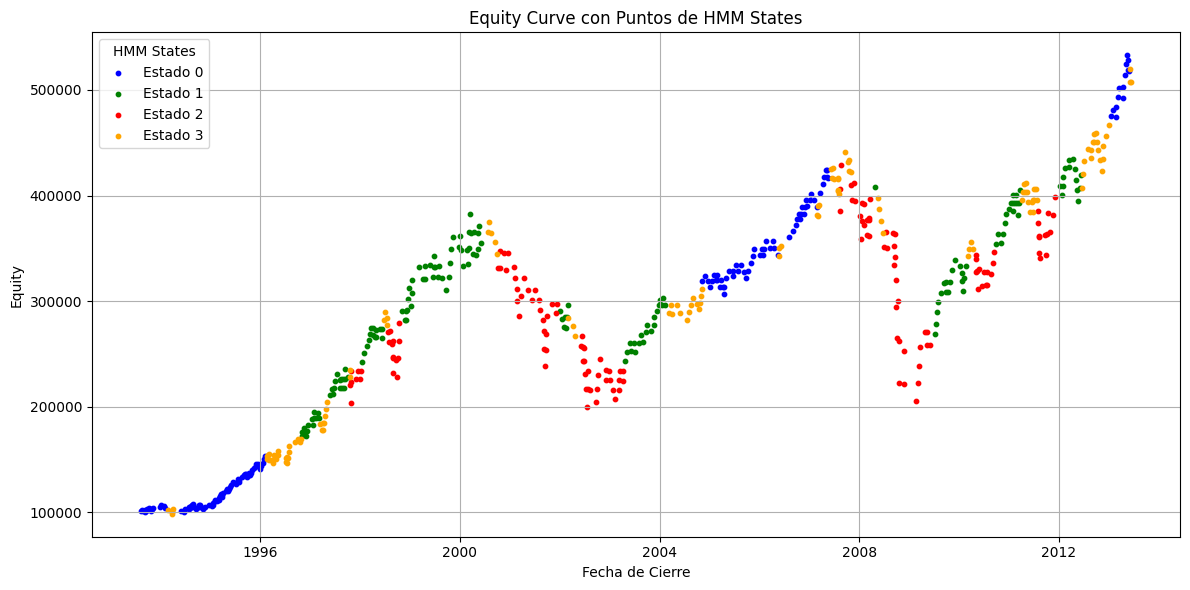

In [23]:
# 1) Calcular la equity curve
capital_inicial = 100_000.0
df_plot = df_train.copy()
df_plot['Equity'] = capital_inicial * (1 + df_plot['Retorno_pct']).cumprod()

# 2) Definir colores para cada estado
color_map = {
    0: 'blue',      # Estado 0 → azul
    1: 'green',       # Estado 1 → rojo
    2: 'red',    # Estado 2 → anaranjado
    3: 'orange',     # Estado 3 → verde
    # Si tuvieras más estados, sigue agregando aquí
}

# 3) Graficar equity y superponer estados con tus colores
fig, ax = plt.subplots(figsize=(12, 6))

for st, color in color_map.items():
    sub = df_plot[df_plot['Estado'] == st]
    if not sub.empty:
        ax.scatter(
            sub['Fecha_Cierre'],
            sub['Equity'],
            color=color,
            s=10,
            label=f'Estado {st}'
        )

# Formato del gráfico
ax.set_title('Equity Curve con Puntos de HMM States')
ax.set_xlabel('Fecha de Cierre')
ax.set_ylabel('Equity')
ax.legend(title='HMM States', loc='best', framealpha=0.8)
ax.grid(True)

plt.tight_layout()
plt.show()

In [24]:
# 1) Extraer covarianzas diagonales
raw_covars = hmm.covars_
if raw_covars.ndim == 3:
    covars = np.array([np.diag(c) for c in raw_covars])
else:
    covars = raw_covars

# 2) Parámetros de los estados
means       = hmm.means_                   # shape (n_states, n_features)
stds        = np.sqrt(covars)              # mismas dimensiones
filtered_states = df_train['Estado'].values
proportions = np.bincount(filtered_states, minlength=hmm.n_components) / len(filtered_states)

# 3) Construir DataFrame de parámetros
df_states = pd.DataFrame({
    'Estado':             np.arange(hmm.n_components),
    'Media_Retornos_10':  means[:, 1],
    'Std_Retornos_10':    stds[:,  1],
    'Media_VIX_Open':     means[:, 0],
    'Std_VIX_Open':       stds[:,  0],
    'Proporción':         proportions
})

df_states

,Estado,Media_Retornos_10,Std_Retornos_10,Media_VIX_Open,Std_VIX_Open,Proporción
0,0,0.055833,0.040780,12.623966,1.437480,0.265442
1,1,0.117425,0.082035,21.621987,3.434351,0.273790
2,2,-0.082826,0.093330,31.612553,9.085849,0.243740
3,3,0.025094,0.043336,17.707083,2.239310,0.217028


In [25]:
# --- Cortes paramétricos (midpoints entre medias HMM) ----------------------
medias = {
    0: {'ret10':  0.055834, 'vix': 12.623954},
    1: {'ret10':  0.117425, 'vix': 21.621983},
    2: {'ret10': -0.082826, 'vix': 31.612549},
    3: {'ret10':  0.025094, 'vix': 17.707069},
}

# midpoints
corte_vix_1     = (medias[0]['vix'] + medias[3]['vix']) / 2
corte_vix_2     = (medias[0]['vix'] + medias[2]['vix']) / 2

corte_ret_pos     = (medias[0]['ret10'] + medias[3]['ret10']) / 2
corte_ret_muy_pos = (medias[0]['ret10'] + medias[1]['ret10']) / 2

# Congela umbrales
VIX_MUY_MAX = corte_vix_1
VIX_FAV_MAX = corte_vix_2
RET_POS_MIN = corte_ret_pos
RET_MUY_MIN = corte_ret_muy_pos

# --- Flags solo para los índices 500 a 599 -------------------------------
# Obtengo el índice real de las filas 500:600
idx_slice = df_barras.index[500:]

# Calculo los flags en ese slice
slice_df = df_barras.loc[idx_slice]
flag_muy = (slice_df['VIX_Open']   < VIX_MUY_MAX) & (slice_df['Retornos_10'] > RET_MUY_MIN)
flag_fav = (slice_df['VIX_Open']   < VIX_FAV_MAX) & (slice_df['Retornos_10'] > RET_POS_MIN)

# Traspaso a df_barras únicamente esas filas
df_barras.loc[idx_slice, 'Flag_Muy_Fav'] = flag_muy
df_barras.loc[idx_slice, 'Flag_Fav']     = flag_fav

In [26]:
df_barras.head()

,Fecha_Cierre,Precio_Cierre,Volume,ATR20,TP,SL,Objetivo,VIX_Open,Retornos_10,Flag_Muy_Fav,Flag_Fav
0,1993-08-16,25.520015,12847800.000000,0.145632,25.811280,25.228750,1,12.370000,0.035692,NaN,NaN
1,1993-08-24,25.811280,1181800.000000,0.139493,26.090266,25.532294,1,11.940000,0.028264,NaN,NaN
2,1993-08-26,26.090266,362300.000000,0.144756,26.379778,25.800753,0,11.850000,0.060551,NaN,NaN
3,1993-09-08,25.800753,1981400.000000,0.150895,26.102544,25.498963,1,12.260000,0.030363,NaN,NaN
4,1993-09-13,26.143034,412600.000000,0.157914,26.458861,25.827206,0,11.670000,0.061148,NaN,NaN


# Backtest

**Buy and Hold**

In [27]:
# 1) Parámetros
capital = 100_000.0

df_bh = df_barras.iloc[500:].copy().reset_index(drop=True)

# 3) Serie de precios y fechas
precios = df_bh['Precio_Cierre']
fechas  = pd.to_datetime(df_bh['Fecha_Cierre'])

# 4) Curva de equity Buy & Hold
equity = capital * (precios / precios.iloc[0])

# 5) Total Return
total_return = equity.iloc[-1] / capital - 1

# 6) CAGR
dias = (fechas.iloc[-1] - fechas.iloc[0]).days
años = dias / 365.25
# Evitamos división por cero si el período es muy corto
cagr = (equity.iloc[-1] / equity.iloc[0]) ** (1/años) - 1 if años > 0 else np.nan

# 7) Retornos por evento y exceso (supuesto RF=0)
retornos     = equity.pct_change().dropna()
ret_exceso   = retornos

# 8) Hit‑Rate: proporción de retornos positivos
hit_rate = (retornos > 0).sum() / len(retornos)

# 9) Sharpe Ratio (annualizado asumiendo 252 eventos por “año”)
sharpe = (ret_exceso.mean() / ret_exceso.std()) * np.sqrt(252) if ret_exceso.std() != 0 else np.nan

# 10) Sortino Ratio
ret_neg = ret_exceso[ret_exceso < 0]
sortino = (ret_exceso.mean() / ret_neg.std()) * np.sqrt(252) if len(ret_neg) > 0 else np.nan

# 11) Maximum Drawdown (MDD)
running_max = equity.cummax()
drawdowns   = (running_max - equity) / running_max
mdd = drawdowns.max()

# 12) Calmar Ratio
calmar = cagr / mdd if mdd != 0 else np.nan

# 13) Time Under Water (TUW)
tuw = (equity < running_max).sum() / len(equity)

# 14) Mostrar resultados
print(f"CAGR:                {cagr:.2%}")
print(f"Sharpe Ratio:        {sharpe:.2f}")
print(f"Sortino Ratio:       {sortino:.2f}")
print(f"Maximum Drawdown:    {mdd:.2%}")
print(f"Calmar Ratio:        {calmar:.2f}")
print(f"Hit‑Rate:            {hit_rate:.2%}")
print(f"Time Under Water:    {tuw:.2%}")

CAGR:                14.46%
Sharpe Ratio:        2.43
Sortino Ratio:       5.54
Maximum Drawdown:    30.67%
Calmar Ratio:        0.47
Hit‑Rate:            58.70%
Time Under Water:    70.91%


In [28]:
df_bt = df_barras.iloc[500:].copy().reset_index(drop=True)

# Abrimos la posición cuando alguna de las columnas "Flag_Muy_Fav" o "Flag_Fav" muestra TRUE
y_pred = np.where((df_bt['Flag_Muy_Fav'] == True) | (df_bt['Flag_Fav'] == True), 1, 0)
df_bt['Signal'] = y_pred

# --- 3) Cálculo de Shares, PnL y Equity (igual que antes) ---
capital_inicial     = 100_000.0
riesgo_pct          = 0.02
spread              = 0.01
comision_por_accion = 0.001
riesgo_abs          = capital_inicial * riesgo_pct

df_bt['EntryPrice'] = df_bt['Precio_Cierre']
df_bt['ExitPrice']  = df_bt['Precio_Cierre'].shift(-1)


mask = df_bt['Signal'] == 1
df_bt['Distance'] = np.nan
df_bt.loc[mask, 'Distance'] = np.abs(df_bt.loc[mask, 'EntryPrice'] - df_bt.loc[mask, 'SL'])

df_bt['Shares'] = 0.0
valid = (df_bt['Signal']==1) & (df_bt['Distance']>0)
df_bt.loc[valid, 'Shares'] = riesgo_abs / df_bt.loc[valid, 'Distance']

df_bt = df_bt.iloc[:-1].copy()  # quitar última fila sin ExitPrice
df_bt['GrossPnL'] = df_bt['Shares'] * (df_bt['ExitPrice'] - df_bt['EntryPrice'])
df_bt['Cost']     = df_bt['Shares'] * (spread + comision_por_accion)
df_bt['NetPnL']   = df_bt['GrossPnL'] - df_bt['Cost']
df_bt['Equity']   = capital_inicial + df_bt['NetPnL'].cumsum()

# --- 5) Resultados de sanity check ---
print("Primeras filas tras corrección:")
print(df_bt[['Signal','EntryPrice','ExitPrice','SL','Distance','Shares','GrossPnL','Cost','NetPnL','Equity']].head(15))

total_return = df_bt['Equity'].iloc[-1] / capital_inicial - 1
print(f"\nTotal Return backtest: {total_return:.2%}")

Primeras filas tras corrección:
    Signal  EntryPrice  ExitPrice        SL  Distance      Shares  \
0        0   80.562995  83.685026 77.440964       NaN    0.000000   
1        0   83.685026  80.466310 80.466310       NaN    0.000000   
2        0   80.466310  83.001382 77.931238       NaN    0.000000   
3        0   83.001382  85.758754 80.244009       NaN    0.000000   
4        0   85.758754  88.318197 83.199311       NaN    0.000000   
5        0   88.318197  90.385224 86.251170       NaN    0.000000   
6        1   90.385224  92.822828 88.181307  2.203916  907.475458   
7        1   92.822828  90.629319 90.629319  2.193509  911.780997   
8        1   90.629319  92.827420 88.431219  2.198100  909.876605   
9        1   92.827420  95.325541 90.329298  2.498122  800.601440   
10       1   95.325541  97.577224 93.073859  2.251682  888.224714   
11       1   97.577224  98.827964 96.326484  1.250740 1599.053821   
12       1   98.827964 100.216589 97.439338  1.388625 1440.273306   
13

In [29]:
# 1) Filtrar trades ejecutados
df_trades = df_bt[df_bt['Shares'] > 0].copy()
total_ops = len(df_trades)

# 2) Curva de equity y fechas reales
equity = df_bt['Equity']
start_date = pd.to_datetime(df_bt['Fecha_Cierre'].iloc[0])
end_date   = pd.to_datetime(df_bt['Fecha_Cierre'].iloc[-1])
years      = (end_date - start_date).days / 365.25

# 3) Total Return
total_return = equity.iloc[-1] / equity.iloc[0] - 1

# 4) Retornos periódicos para Sharpe/Sortino
rets = df_bt['NetPnL'] / equity.iloc[0]
rets = rets.dropna()
events_per_year = len(rets) / years

mean_ret = rets.mean()
std_ret  = rets.std(ddof=0)
sharpe   = (mean_ret / std_ret) * np.sqrt(events_per_year)

neg_rets = rets[rets < 0]
sortino  = (mean_ret / neg_rets.std(ddof=0)) * np.sqrt(events_per_year)

# 5) CAGR real
gagr = (equity.iloc[-1] / equity.iloc[0]) ** (1/years) - 1

# 6) Drawdown y Calmar
running_max = equity.cummax()
drawdowns   = (running_max - equity) / running_max
mdd         = drawdowns.max()
calmar      = gagr / mdd

# 7) Hit-Rate y Profit Factor
trade_pnls    = df_trades['NetPnL']
hit_rate      = (trade_pnls > 0).mean()
wins          = trade_pnls[trade_pnls > 0].sum()
loses         = -trade_pnls[trade_pnls < 0].sum()
profit_factor = wins / loses if loses > 0 else np.nan

# 8) Time Under Water (TUW)
tuw = (equity < running_max).mean()


# 10) Mostrar resultados
print("=== Resumen Métricas Backtest ===")
print(f"Total operaciones    : {total_ops}")
print(f"Total Return         : {total_return:.2%}")
print(f"CAGR                 : {gagr:.2%}")
print(f"Sharpe Ratio         : {sharpe:.2f}")
print(f"Sortino Ratio        : {sortino:.2f}")
print(f"Maximum Drawdown     : {mdd:.2%}")
print(f"Calmar Ratio         : {calmar:.2f}")
print(f"Hit-Rate             : {hit_rate:.2%}")
print(f"Profit Factor        : {profit_factor:.2f}")
print(f"Time Under Water     : {tuw:.2%}")

=== Resumen Métricas Backtest ===
Total operaciones    : 248
Total Return         : 65.25%
CAGR                 : 3.46%
Sharpe Ratio         : 0.52
Sortino Ratio        : 2.33
Maximum Drawdown     : 17.91%
Calmar Ratio         : 0.19
Hit-Rate             : 57.26%
Profit Factor        : 1.29
Time Under Water     : 89.47%


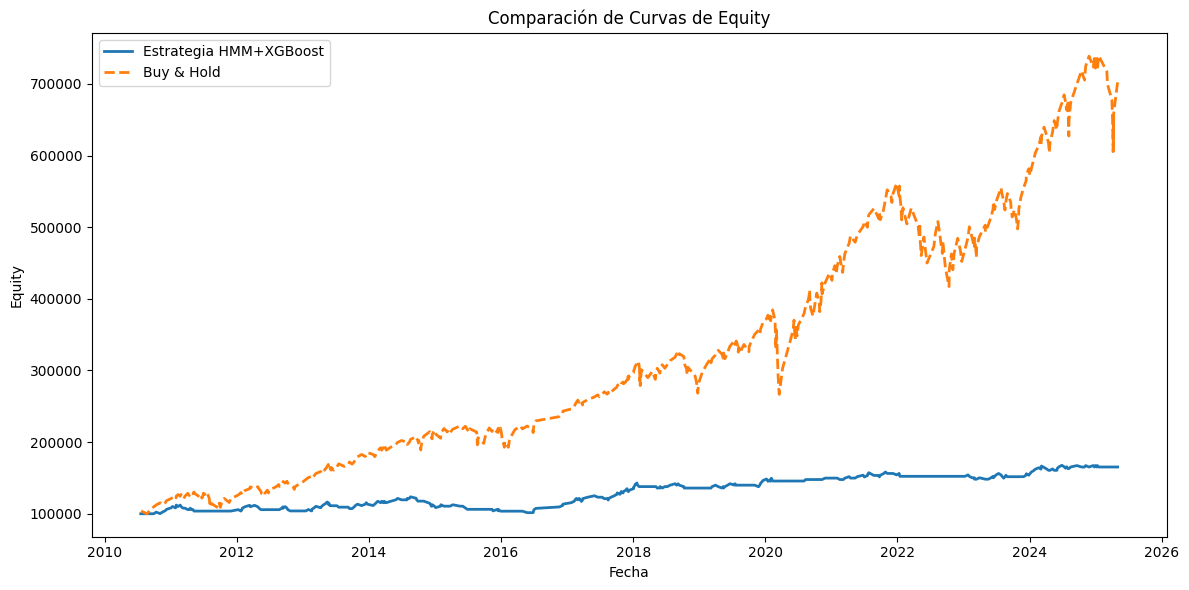

In [30]:
# --- Asume que tienes df_bt y df_train definidos ---
# Capital inicial
capital_inicial = 100_000.0

# 1) Prepara la curva de tu estrategia
# df_bt debe tener columnas 'Fecha_Cierre' (datetime) y 'Equity'
df_bt['Fecha_Cierre'] = pd.to_datetime(df_bt['Fecha_Cierre'])

# 2) Calcula la curva de Buy & Hold sobre los mismos precios de cierre de df_bt
prices_bh = df_bt['Precio_Cierre']
rets_bh   = prices_bh.pct_change().dropna()
equity_bh = capital_inicial * (1 + rets_bh).cumprod()
dates_bh  = df_bt['Fecha_Cierre'].iloc[1:]  # cae un elemento por el pct_change

# 3) Graficar ambas curvas
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_bt['Fecha_Cierre'], df_bt['Equity'], label='Estrategia HMM+XGBoost', linewidth=2)
ax.plot(dates_bh, equity_bh,       label='Buy & Hold',              linewidth=2, linestyle='--')

ax.set_title('Comparación de Curvas de Equity')
ax.set_xlabel('Fecha')
ax.set_ylabel('Equity')
ax.legend()
plt.tight_layout()
plt.show()